In [73]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [74]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index



78


In [75]:
news_df = pd.read_csv(data_dir + "topic_sentiment.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

news_df.drop(['tokens', 'yyyy-mm'], axis=1, inplace=True)
news_features = create_news_features(news_df.columns[5:])
news_features


,hunger,conflict,humanitarian,refugees,politics,economics,production,land,pests,environment,major,topic,sentiment,difference
date,,,,,,,,,,,,,,
2011-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,0.022222,0.0,0.050000,0.000000,4.625929e-18,0.000000,0.055556,4.625929e-18,1.850372e-17,1.850372e-17,0.055556,12.183761,0.283412,0.283412
2023-01-01,0.022222,0.0,0.050000,0.000000,5.555556e-02,0.000000,0.055556,4.625929e-18,1.850372e-17,5.555556e-02,0.055556,13.305556,-0.021430,-0.021430
2023-02-01,0.083333,0.0,0.069444,0.000000,5.555556e-02,0.083333,0.138889,8.333333e-02,1.250000e-01,1.388889e-01,0.097222,13.069444,-0.048976,-0.048976


In [76]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

In [77]:
df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

In [78]:
df.iloc[:, -24:]

,,year,month,ipc,ha,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,...,cropland_pct,pop,ruggedness_mean,pasture_pct,count_violence_lag_3,ndvi_anom_lag_3,food_price_idx_lag_3,ipc_lag_1,ipc_lag_2,ipc_lag_3
date,district,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,2007,1,NaN,NaN,0.345851,114.3253,0.253903,-0.107226,0.671249,0.048880,...,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-01,Bor,2007,2,NaN,NaN,0.307600,119.8153,1.018789,0.133927,0.129184,-0.457928,...,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-01,Bor,2007,3,NaN,NaN,0.278344,110.3800,2.001045,-2.164728,1.025460,-0.590175,...,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-01,Bor,2007,4,NaN,NaN,0.303320,102.3160,12.831140,-0.332849,3.846809,-1.845536,...,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-01,Bor,2007,5,NaN,NaN,0.413716,97.1873,19.274320,0.288466,8.316274,-2.972735,...,7.961984,239344.0,11393.760,90.8503,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,Malakal,2019,10,3.0,0.0,0.681990,113.3705,14.913800,2.580618,22.853360,6.053181,...,13.068690,102228.0,7145.909,85.5000,0.000000,102.755628,2.096042,3.0,3.0,3.0
2019-11-01,Malakal,2019,11,NaN,NaN,0.556748,116.7530,0.645686,-0.091687,13.372410,8.745254,...,13.068690,102228.0,7145.909,85.5000,0.000000,103.497230,2.904992,NaN,NaN,NaN
2019-12-01,Malakal,2019,12,NaN,NaN,0.400063,117.5583,0.046705,-0.000951,3.089540,1.698060,...,13.068690,102228.0,7145.909,85.5000,0.000000,104.682503,3.090600,NaN,NaN,NaN


In [79]:
X = df.iloc[:, -24:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

In [80]:
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
    .join(news_df.groupby(["date"])["politics"].mean())
    .join(news_df.groupby(["date"])["economics"].mean())
    .join(news_df.groupby(["date"])["production"].mean())
    .join(news_df.groupby(["date"])["land"].mean())
    .join(news_df.groupby(["date"])["pests"].mean())
    .join(news_df.groupby(["date"])["environment"].mean())
    .join(news_df.groupby(["date"])["major"].mean())
    .join(news_df.groupby(["date"])["difference"].mean())
)


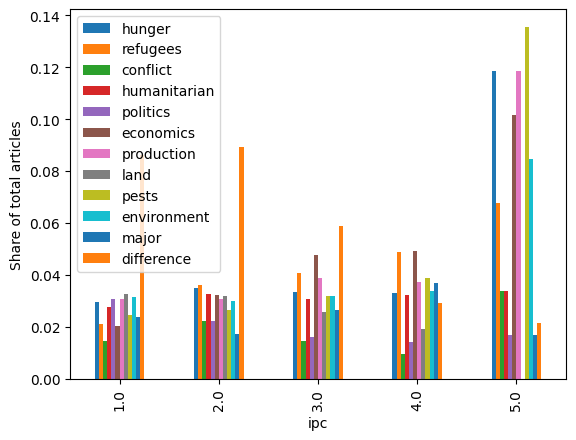

In [81]:
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian", 
                         "politics", "economics", "production", "land", "pests", 
                         "environment", "major", "difference"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

In [82]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [83]:
df_no_na=df.copy()
df_no_na.dropna(inplace=True)
### USE IF DONT WANT NAN

In [84]:
def evaluate(predy, y):
    '''
    Function to evaluate the performance of a model by calculating the accuracy score and plotting the confusion matrix.
    
    Inputs:
        predy - The predicted values
        y - The true values
        
    Output:
        accuracy - The accuracy score of the model
        confusion_matrix - The confusion matrix of the model
    '''
    precision_by_class = {i+1: [] for i in range(5)} 
    recall_by_class = {i+1: [] for i in range(5)}
    accuracy = accuracy_score(y, predy)
    print(f"Accuracy score: {accuracy}")
    # confusion_matrix = plot_ConfusionMatrix(predy, y)
    # print(confusion_matrix)
    # for i in range(5):
    #     precision_by_class[i+1] = confusion_matrix.iloc[i,i]/sum(confusion_matrix.iloc[:,i])
    #     recall_by_class[i+1] = confusion_matrix.iloc[i,i]/sum(confusion_matrix.iloc[i,:])
    precision, recall, a, b= precision_recall_fscore_support(y, predy, average=None, labels=range(1, 6), zero_division=0)

    for i in range(5):
        precision_by_class[i+1].append(precision[i])
        recall_by_class[i+1].append(recall[i])

    
    return accuracy, precision_by_class, recall_by_class


In [85]:
def preprocess(y_pred,y_true):

    # Round prediction to nearest integer (i.e. the nearest phase)
    pred = y_pred.round() 
    pred = np.minimum(pred, 5) # Cap maximum prediction at 5 (maximum phase)
    pred = np.maximum(pred, 1) # Cap minimum prediction at 1 (minimum phase)

    true = y_true.dropna() # drop NaN values
    pred = pred.dropna()

    return true, pred

In [87]:
X = df.iloc[:, -24:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

Xcopy = X.copy()
Xcopy.dropna(inplace=True)
vif = [variance_inflation_factor(Xcopy.values, i) 
                        for i in range(len(Xcopy.columns))] 
print(vif)

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    y_pred, y_val = preprocess(y_pred, y_val) # Preprocess predictions and true values
    y_val = pd.DataFrame(y_val) # Convert y_val to DataFrame

    print(evaluate(y_pred['ipc'], y_val[0])) # Evaluate model (print accuracy score and plot confusion matrix)
    # Append results to respective lists
    # mae_values.append((y_pred - y_val[0]).abs().mean())
    r2_values.append(results.rsquared)


    # plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    # plot_ConfusionMatrix(prediction = y_pred, true = y_val[0]) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

MissingDataError: exog contains inf or nans

In [ ]:
y_pred

ipc
date       district          
2011-04-01 Kapoeta East   2.0
           Kapoeta North  2.0
           Kapoeta South  2.0
           Koch           2.0
           Lafon          3.0
...                       ...
2013-01-01 Nagero         1.0
           Nasir          1.0
           Nyirol         2.0
           Panyijiar      2.0
           Panyikang      1.0

[572 rows x 1 columns]

Optimization terminated successfully.
         Current function value: 0.023951
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  962
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.7213
Time:                        11:43:06   Log-Likelihood:                -23.041
converged:                       True   LL-Null:                       -82.676
Covariance Type:            nonrobust   LLR p-value:                 1.108e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9214      2.560     -6.610      0.000     -21.939     -11.904
ipc_lag_1      7.5452      1

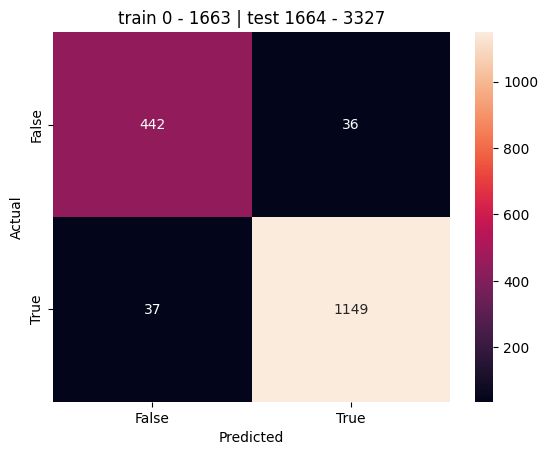

Optimization terminated successfully.
         Current function value: 0.196510
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 2626
Model:                          Logit   Df Residuals:                     2622
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.4129
Time:                        11:43:07   Log-Likelihood:                -516.04
converged:                       True   LL-Null:                       -878.95
Covariance Type:            nonrobust   LLR p-value:                5.241e-157
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0771      0.344    -23.471      0.000      -8.752      -7.403
ipc_lag_1      3.0044      0.

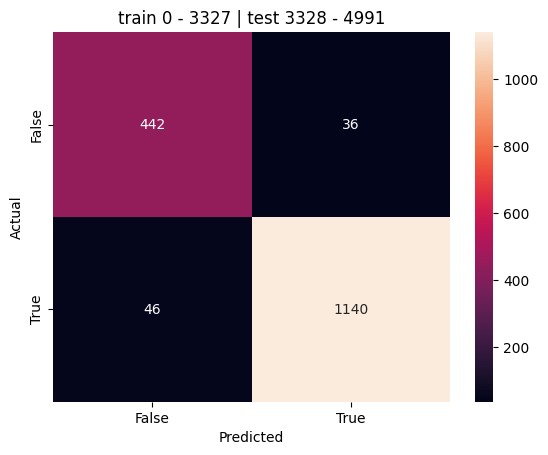

Optimization terminated successfully.
         Current function value: 0.220939
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 4290
Model:                          Logit   Df Residuals:                     4286
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.3941
Time:                        11:43:07   Log-Likelihood:                -947.83
converged:                       True   LL-Null:                       -1564.4
Covariance Type:            nonrobust   LLR p-value:                4.853e-267
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8526      0.262    -29.949      0.000      -8.367      -7.339
ipc_lag_1      2.9520      0.

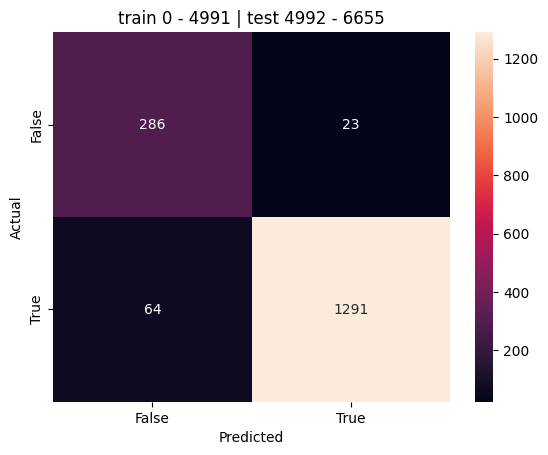

Optimization terminated successfully.
         Current function value: 0.263542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 5954
Model:                          Logit   Df Residuals:                     5950
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.4349
Time:                        11:43:08   Log-Likelihood:                -1569.1
converged:                       True   LL-Null:                       -2776.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8860      0.209    -37.780      0.000      -8.295      -7.477
ipc_lag_1      2.8618      0.

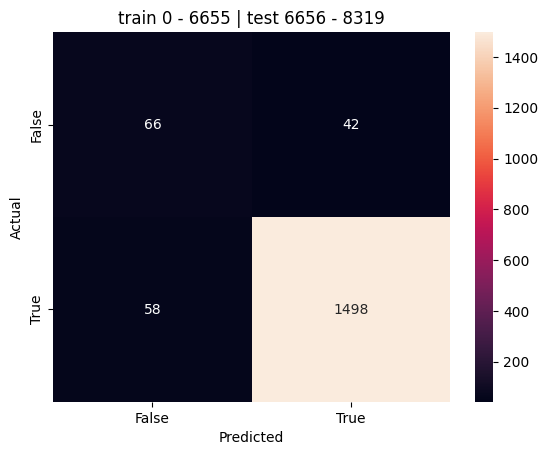

Optimization terminated successfully.
         Current function value: 0.297659
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 7618
Model:                          Logit   Df Residuals:                     7614
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.5120
Time:                        11:43:08   Log-Likelihood:                -2267.6
converged:                       True   LL-Null:                       -4646.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2706      0.182    -45.491      0.000      -8.627      -7.914
ipc_lag_1      2.6647      0.

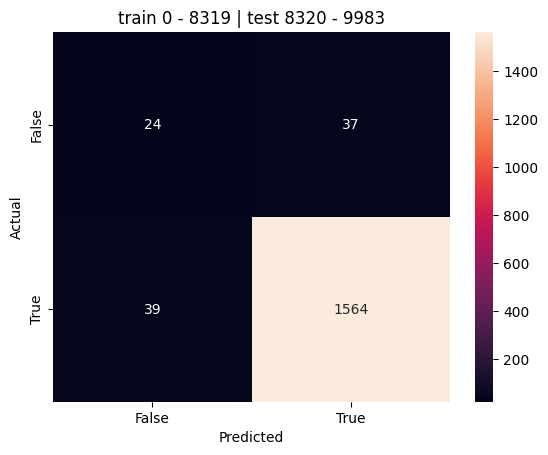

Mean Acc: 0.95


<Figure size 640x480 with 0 Axes>

In [ ]:
X = df.iloc[:, -24:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc

In [ ]:
y_pred

date        district  
2018-05-01  Pariang            NaN
            Pibor              NaN
            Pigi               NaN
            Pochalla           NaN
            Raja               NaN
                            ...   
2020-02-01  Wulu          2.799912
            Yambio        2.757577
            Yei           3.554900
            Yirol East    3.822865
            Yirol West    3.801320
Length: 1664, dtype: float64

### RANDOM FOREST

In [ ]:
print(len(df))
df.interpolate(inplace=True)
df=df.dropna()
print(len(df))


9984
7410


In [ ]:
from sklearn.ensemble import RandomForestRegressor


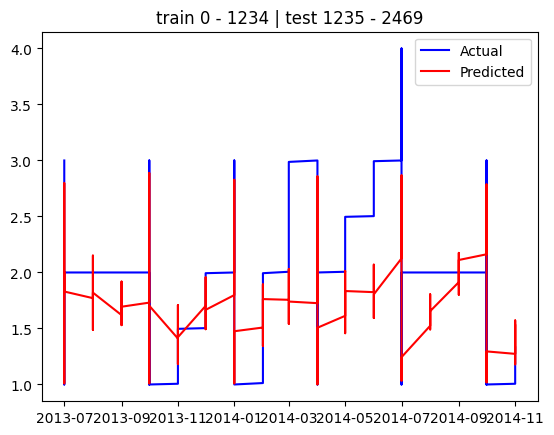

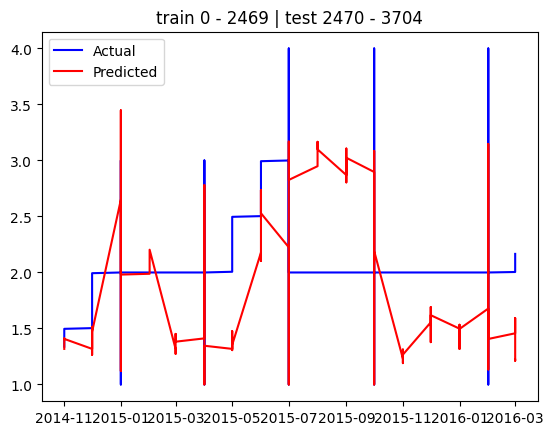

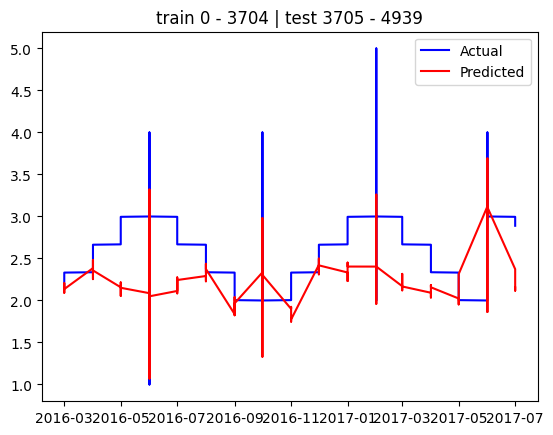

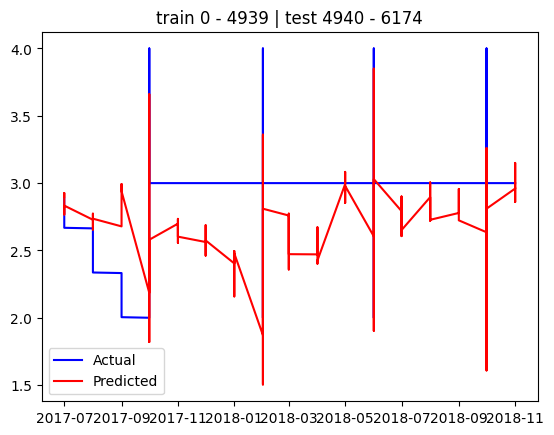

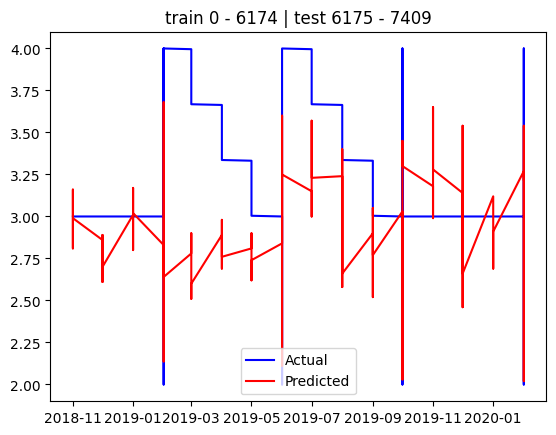

Mean MAE: 0.43
Mean R2: -0.46


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Define explanatory variables and target data
X = df.iloc[:, -24:]
y = df[["ipc"]]

cv = TimeSeriesSplit(n_splits=5)  # Define TimeSeriesSplit with 5 splits

# Initialize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X):  # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any new features, drop those columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]

    # Interpolate training data
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Initialize and train the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100)  # You can adjust the number of estimators
    rf.fit(X_train, y_train.values.ravel())

    y_pred = rf.predict(X_test)

    # Append results to respective lists
    mae_values.append(mean_absolute_error(y_val, y_pred))
    r2_values.append(r2_score(y_val, y_pred))

    # Plotting the results
    plt.figure()
    plt.plot(y_val.index.get_level_values(0), y_val, label='Actual', color='blue')  # Use timestamps only for x-axis
    plt.plot(y_val.index.get_level_values(0), y_pred, label='Predicted', color='red')  # Use timestamps only for x-axis
    plt.legend()
    plt.title(f'train {train_index[0]} - {train_index[-1]} | test {val_index[0]} - {val_index[-1]}')
    plt.show()

print(f"Mean MAE: {np.mean(mae_values):.2f}")  # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}")  # Print R2
